# Verifier's Dilemma

A description of the Verifier's Dilemma is posed in Section 3.1 of the TrueBit Whitepaper

https://people.cs.uchicago.edu/~teutsch/papers/truebit.pdf

which itself is a synopsis of the concept presented in this scholarly work

https://eprint.iacr.org/2015/702.pdf

In this simulation the underlying implementation details are abstracted and the economic incentives associated with the choice to cheat, and choice to commit resources to serve as a validator are explored using a differential game. We specifically, assume that the prerequisites posed are met: verification is expensive and verifiers do not undertake the task unless their is an expected ROI associated with incentives for catching cheaters, including accounting for the verifier's belief that cheaters will be present to catch.


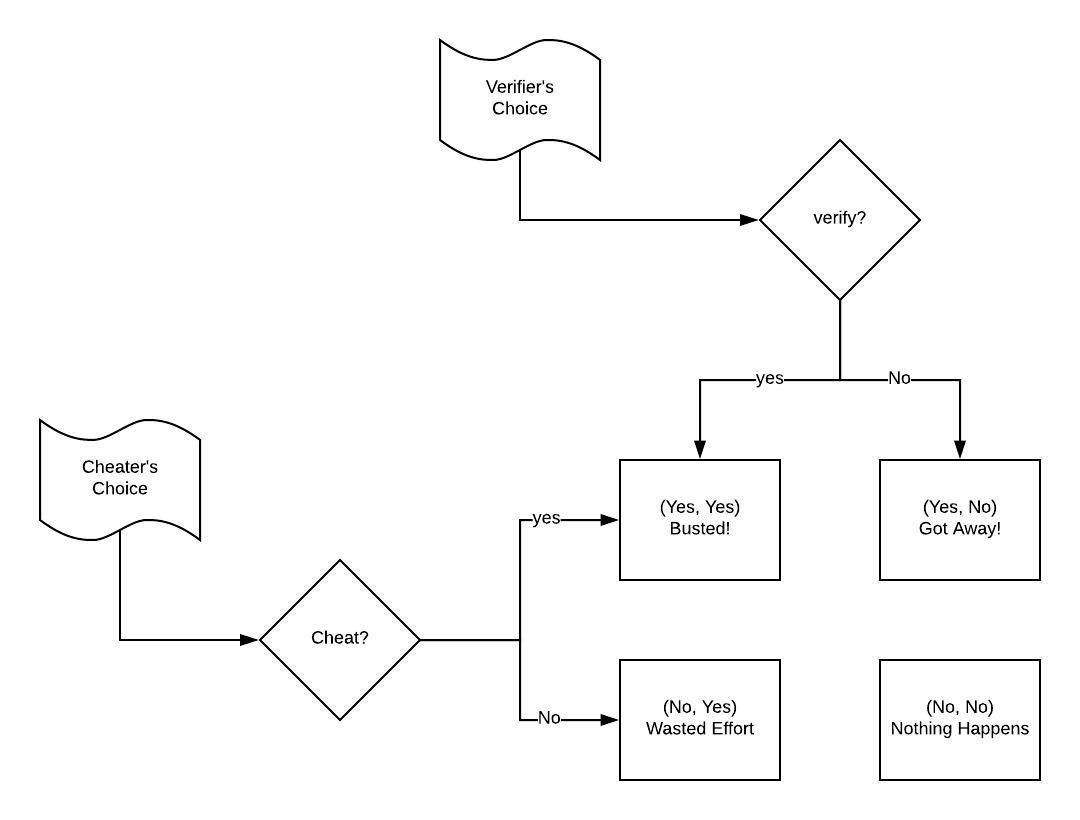

In [1]:
from IPython.display import Image
Image(filename='Dilemma.jpeg')

At each point in time both Verifier's and Cheaters must make a decision about whether or not to act. What this characterization fail's to get at is the temporal feedback loop caused by the computing the Cheaters and Verifiers beliefs about the expected returns on their actions as estimated by their observations of the other's actions over time. 

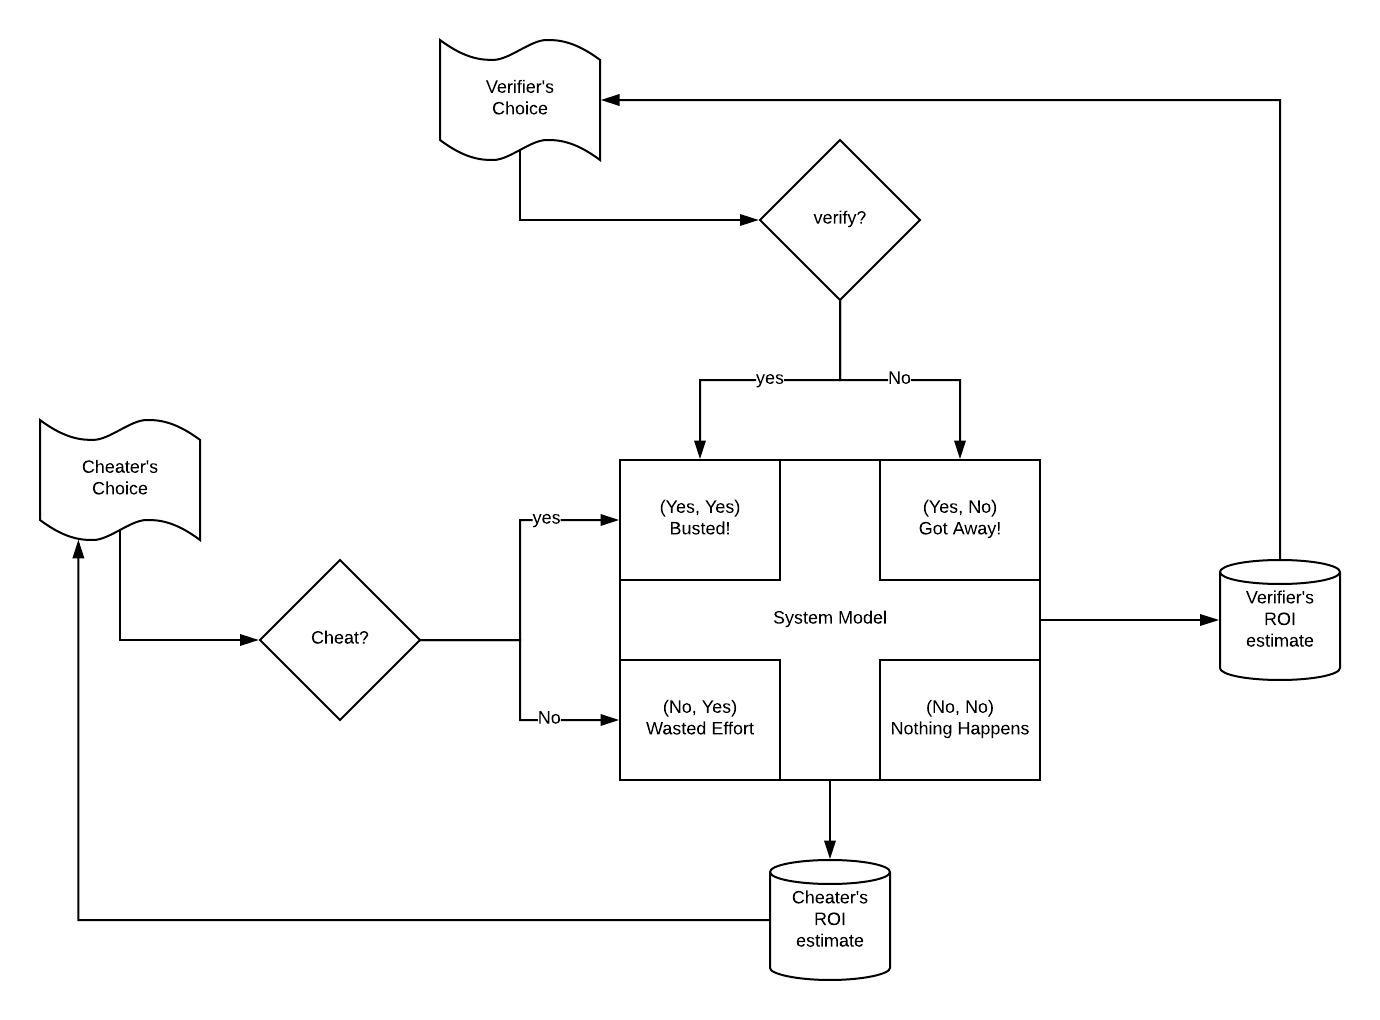

In [2]:
Image(filename='feedback.jpeg')

Once we introduce feedback, and introduce a temporal dimension to the choices of the actors, even a highly simplified model of this game fails to achieve an equilibrium. The dynamics fall into a class of preditor-prey like oscillations where one group (prey) thrives when the other is absent but other group (preditors) thrive when the first is plentiful.

Mathematically, the key aspect of a differential game is the decomposition of the mapping from actions to rewards to include state.

Standard Game:

$\vec{Rewards} = Utility(\vec{actions})$

and strategies are analyzed based on Nash Equilibria which are defined by action profiles across players for which there is no unilateral incentive for a player to deviate; that is no player can improve his reward (payoff) by change his/her action assuming all other players actions stay the same.

Differential Game:

$\vec{state}^+ = F(\vec{state}, \vec{actions})$

$\vec{Rewards} = Utility(\vec{state}^+)-Cost(\vec{actions})$

In this case strategies are defined as state dependent 'Policies' which are functions

$\vec{action} = P(\vec{state})$

where these policies depend on the state and may include dependence beliefs about other players, estimates of unobservable states, or private signals. The resulting systems may have their equilibria (or lack thereof) analyzed using a variety of methods from the decision & control theory literature.

In this notebook, we explore the "Non-Equibrium Dynamics" that arise from introducing ROI estimation as feedback to decision policies of both cheaters and verifiers. More text discussion of th topic may be found here:
https://medium.com/@michaelzargham/hi-b26f215dc6f8

In [3]:
from datetime import timedelta

from SimCAD import configs
from SimCAD.configuration import Configuration
from SimCAD.configuration.utils import exo_update_per_ts, proc_trigger, bound_norm_random, \
    ep_time_step

In [4]:
#define number of experiments N, and the length of each experiment with T
sim_config = {
    'N': 1,
    'T': range(100)
}

#this variable defines the time period assumed for each period in T
ts_format = '%Y-%m-%d %H:%M:%S'
t_delta = timedelta(days=0, minutes=1, seconds=0)
def time_model(step, sL, s, _input):
    y = 'timestamp'
    x = ep_time_step(s, dt_str=s['timestamp'], fromat_str=ts_format, _timedelta=t_delta)
    return (y, x)

In [5]:
#used with stochastic processes to make experiments repeatable
seed = {}

# Initial Conditions
genesis_states = {
    'Verifiers_On': True, #verifiers are active
    'Cheaters_On': False, #cheaters are inactive
    'Total_Volume': 100, #volume of transaction activity
    'Honest_Volume': 100, #volume of honest transaction activity
    'Cheats_Volume': 0, #volume of cheating transaction activity
    'Cheats_Caught_Volume': 0, #volume of cheating that was caught
    'Verifiers_Cost': 0, #cost incurred by verifiers
    'Verifiers_Reward': 0, #rewards collected by verifiers
    'Cheaters_Cost': 0, #costs incurred by cheaters
    'Cheater_Reward': 0, #rewards (profit) achieved by cheating 
    'timestamp': '2018-01-01 00:00:00'
}

State Dependant Reward and Cost Functions which characterize the players utilities

In [6]:
# Verifier's cost per transaction verified
alfa = 0.001
def verifier_cost(s):
    return alfa * (s['Total_Volume'])

# Verifier's reward per cheat caught
beta = 4 
def verifier_reward(s):
    return beta * s['Cheats_Volume']

# Cheater's reward per transaction sent successfully
gamma = 1
def cheater_reward(s):
    return gamma * (s['Cheats_Volume'])

# Cheater's cost per cheat caught
delta = 5
def cheater_cost(s):
    return delta * s['Cheats_Caught_Volume']



## Behaviors

In this section Policies are defined for our cheaters and verifiers choices

In [7]:
# Behaviors

# verifiers required expected profit threshold before verifying
# this is a simple ROI threshold policy
theta = .1
def verifier(step, sL, s):
    act = False
    if (verifier_expected_reward(s) > (1+theta)*verifier_cost(s)):
        act = True
    return {'verifier': act}

#in order to implement the ROI heuristic for verifiers we need an estimator for Expected Rewards
def verifier_expected_reward(s):
    '''
    We assume the existence of an off-chain signaling mechanism 
    by which potential verifiers become aware of some of cheating volume.
    The gain of this signal is small because the assumption is it hearsay
    '''
    off_chain_cheating_signal = 0.01 #hearsay
    off_chain_expected_cheating = off_chain_cheating_signal * s['Cheats_Volume']
    on_chain_expected_cheating = s['Cheats_Caught_Volume']
    return beta * max([off_chain_expected_cheating, on_chain_expected_cheating])

# cheater's ROI threshold collapses to simply
# cheat if there are no verifiers
# don't cheat if there are verifiers
def cheater(step, sL, s):
    act = not(s['Verifiers_On'])
    return {'cheater': act}

## Mechanisms

In this modeling framework, mechanisms are the "actuators" meaning that when a policy outputs a decision to take an action that action causes a change to the system state that may or may not be the intent of the actor. In this example, verifiers and cheaters are either present or absent but the state of the system that determines rewards (payoffs) is the pair. In this way, the model presented is still very close in structure to a repeated game model. For more on games see: https://www.ece.ucsb.edu/~jrmarden/files/marsha2017.pdf

In [8]:
#direct handling of actions to set state variables
def commit_resources_to_verifying(step, sL, s, _input):
    y = 'Verifiers_On'
    x = _input['verifier']
    return (y, x)

def commit_resources_to_cheating(step, sL, s, _input):
    y = 'Cheaters_On'
    x = _input['cheater']
    return (y, x)

In [9]:
# these mechanisms are for state updates are computed from other states
# due to the simplicity of this model; 
# exogenous states, and exogenous process features of the simulation framework are used
# these models can also be handled as standard states and mechanism 
# with only minor changes to the config

#the total volume is modeled as static but changing epsilon to a random variable
#is a simple way to introduce a stochastic process to make Monte Carlo simulations interesting
epsilon = 1
def volume_ep(step, sL, s, _input):
    y = 'Total_Volume'
    x = epsilon*s['Total_Volume']
    return (y, x)

#zeta is the percentage of the total volume which is cheating volume
#extend this model by making zeta an output of a Policy or a random variable
zeta=0.2
def cheat_volume_ep(step, sL, s, _input):
    y = 'Cheats_Volume'
    if (s['Cheaters_On']):
        x = zeta*(s['Total_Volume'])
    else:
        x = 0
    return (y, x)

#honest volume is the complement of the cheat volume
def honest_volume_ep(step, sL, s, _input):
    y = 'Honest_Volume'
    if (s['Cheaters_On']):
        x = (1-zeta)*s['Total_Volume']
    else:
        x = s['Total_Volume']
    return (y, x)

#resolve the cheat volume caught being caught
def cheats_caught_ep(step, sL, s, _input):
    y = 'Cheats_Caught_Volume'
    if (s['Verifiers_On']):
        x = s['Cheats_Volume']
    else:
        x = 0
    return (y, x)

#resolve the costs incurred by verifiers verifying transactions
def verifier_cost_ep(step, sL, s, _input):
    y = 'Verifiers_Cost'
    if (s['Verifiers_On']):
        x = verifier_cost(s)
    else:
        x = 0
    return (y, x)

#resolve the rewards earned by verifiers verifying transactions
def verifier_reward_ep(step, sL, s, _input):
    y = 'Verifiers_Reward'
    if (s['Verifiers_On']):
        x = verifier_reward(s)
    else:
        x = 0
    return (y, x)

#resolve the costs incurred by cheaters getting caught
def cheater_cost_ep(step, sL, s, _input):
    y = 'Cheaters_Cost'
    if (s['Verifiers_On']):
        x = cheater_cost(s)
    else:
        x = 0
    return (y, x)

#resolve the rewards won by cheaters getting away with cheating
def cheater_reward_ep(step, sL, s, _input):
    y = 'Cheater_Reward'
    if (s['Cheaters_On']):
        x = cheater_reward(s)
    else:
        x = 0
    return (y, x)


# store the state and state update functions 
#as "exogenous_states" updated as "ep" = "exogenous process"
# note this terminology is being deprecated 
# as it confuses internal dynamics with models of processes
# which occur outside of but have influence on our system
exogenous_states = exo_update_per_ts(
    {
    'Total_Volume': volume_ep,
    'Honest_Volume': honest_volume_ep,
    'Cheats_Volume': cheat_volume_ep,
    'Cheats_Caught_Volume': cheats_caught_ep,
    'Verifiers_Cost': verifier_cost_ep,
    'Verifiers_Reward': verifier_reward_ep,
    'Cheaters_Cost': cheater_cost_ep,
    'Cheater_Reward': cheater_reward_ep,
    'timestamp': time_model
    }
)

#not used in this simulation
env_processes = {
}



In [10]:
#wire together the partial state update blocks ~ see Robot and Marbles tutorials for more details
mechanisms = {
    'commit': {
        'behaviors': {
            'verifier': verifier,
            'cheater': cheater
        },
        'states': { 
            'Verifiers_On': commit_resources_to_verifying,
            'Cheaters_On': commit_resources_to_cheating            
        }
    }
}

In [11]:
configs.append(
    Configuration(
        sim_config=sim_config,
        state_dict=genesis_states,
        seed=seed,
        exogenous_states=exogenous_states,
        env_processes=env_processes,
        mechanisms=mechanisms
    )
)

# Run the engine

In [12]:
from SimCAD.engine import ExecutionMode, ExecutionContext, Executor
# from demos import simple_tracker_config
from SimCAD import configs
exec_mode = ExecutionMode()

single_config = [configs[0]]
single_proc_ctx = ExecutionContext(exec_mode.single_proc)
run = Executor(single_proc_ctx, single_config)
run_raw_result = run.main()[0]

single_proc: [<SimCAD.configuration.Configuration object at 0x113b45d68>]


# Analyze the results

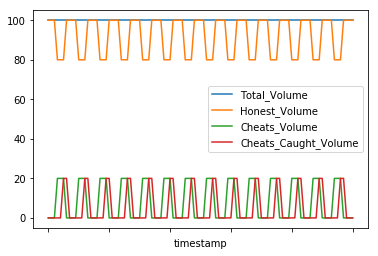

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
result = pd.DataFrame(run_raw_result)
result.plot('timestamp', 
            ['Total_Volume',
             'Honest_Volume',
             'Cheats_Volume',
             'Cheats_Caught_Volume'])

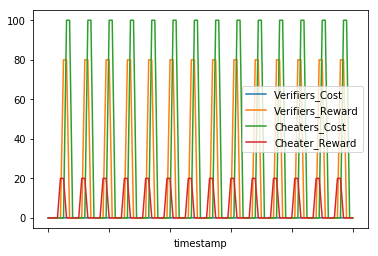

In [14]:
result.plot('timestamp', ['Verifiers_Cost',
             'Verifiers_Reward',
             'Cheaters_Cost',
             'Cheater_Reward'])

In [15]:
result.head(20)

,Cheater_Reward,Cheaters_Cost,Cheaters_On,Cheats_Caught_Volume,Cheats_Volume,Honest_Volume,Total_Volume,Verifiers_Cost,Verifiers_On,Verifiers_Reward,mech_step,run,time_step,timestamp
0,0.0,0.0,False,0.0,0.0,100.0,100,0.0,True,0.0,0,1,0,2018-01-01 00:00:00
1,0.0,0.0,0,0.0,0.0,100.0,100,0.1,0,0.0,1,1,1,2018-01-01 00:01:00
2,0.0,0.0,1,0.0,0.0,100.0,100,0.0,0,0.0,1,1,2,2018-01-01 00:02:00
3,0.0,0.0,1,0.0,20.0,80.0,100,0.0,0,0.0,1,1,3,2018-01-01 00:03:00
4,20.0,0.0,1,0.0,20.0,80.0,100,0.0,1,0.0,1,1,4,2018-01-01 00:04:00
5,20.0,0.0,0,20.0,20.0,80.0,100,0.1,1,80.0,1,1,5,2018-01-01 00:05:00
6,0.0,100.0,0,20.0,0.0,100.0,100,0.1,1,80.0,1,1,6,2018-01-01 00:06:00
7,0.0,100.0,0,0.0,0.0,100.0,100,0.1,1,0.0,1,1,7,2018-01-01 00:07:00
8,0.0,0.0,0,0.0,0.0,100.0,100,0.1,0,0.0,1,1,8,2018-01-01 00:08:00
9,0.0,0.0,1,0.0,0.0,100.0,100,0.0,0,0.0,1,1,9,2018-01-01 00:09:00


I set it up so that the rewards net out on average, funneling the cheater penalties to verifiers. In the section below, we use the pandas builtins to compute some extra fields to explore the financial flows

In [16]:
result["Cumulative_Cheating_Volume"]= result['Cheats_Volume'].cumsum()
result["Cumulative_Cheating_Rewards"]= result['Cheater_Reward'].cumsum()

result["Cumulative_Verifiers_Cost"]= result['Verifiers_Cost'].cumsum()
result["Cumulative_Verifier_Rewards"]= result['Verifiers_Reward'].cumsum()

result["Cumulative_Cheating_Penalties"]= result['Cheaters_Cost'].cumsum()
result["Cumulative_Cheating_Profit"] = result["Cumulative_Cheating_Rewards"]-result["Cumulative_Cheating_Penalties"]

result["Cumulative_Verifier_Profit"] = result["Cumulative_Verifier_Rewards"]-result["Cumulative_Verifiers_Cost"]
result["Cumulative_Verifier_ROI"] = result["Cumulative_Verifier_Profit"]/result["Cumulative_Verifiers_Cost"]

result["Running_Cheating_Volume_Fraction"]=result["Cumulative_Cheating_Volume"]/result["Total_Volume"].cumsum()

result["Cumulative_Net_Profit"] = result["Cumulative_Verifier_Profit"] + result["Cumulative_Cheating_Profit"]

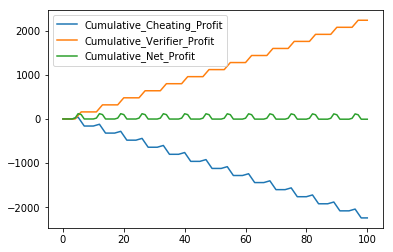

In [17]:
result[['Cumulative_Cheating_Profit', "Cumulative_Verifier_Profit", "Cumulative_Net_Profit"]].plot()

Despite the favoriable net-flow of funds from cheaters to verifiers, the non-equilibrium dynamics in this system actually result in a steady state cheating rate.

0.084


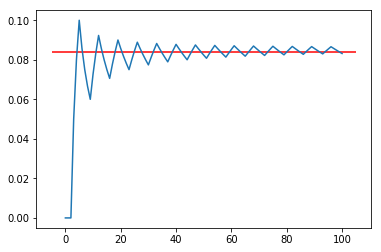

In [18]:
result["Running_Cheating_Volume_Fraction"].plot()
h = result["Running_Cheating_Volume_Fraction"].median()
ax = plt.axis()
plt.hlines(h, ax[0], ax[1], 'r')
print(h)

The steady state cheating is not wholly bad because that cheating is in fact the source of steady state ROI for verifiers.

390.83673469387764


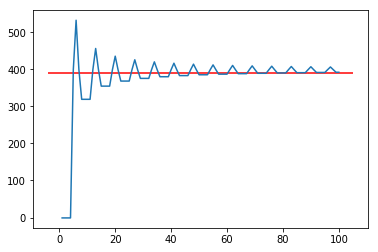

In [19]:
result["Cumulative_Verifier_ROI"].plot()
h = result["Cumulative_Verifier_ROI"].median()
ax = plt.axis()
plt.hlines(h, ax[0], ax[1], 'r')
print(h)

By understanding the temporal dynamics of a game it is possible to get a much clearer understanding of what is going on and to make decisions about trade-offs. In this case, one can monitor and manage cheating rates but through proper routing of the penalties to verifiers to ensure cheating remains bounded and the system stays self-sustaining.

In practice, I prefer the solution like that of Truebit; the persistent cheating problem is solved by introducing forced errors. This creates a continuous incentive for verifiers to be present, driving out steady state error but this eliminates the net revenue balance by introducing an overhead cost for rewarding verifiers to catch the fake errors.

Bonus Points ~ extend this notebook to include the forced errors solution and explore how it changes the financial net-flows. 
- What additional behaviors need to be modeled and what should their policies be?
- Who should bear the cost of paying to subsidize the forced errors? 
- What happens to the system if verifiers can identify and cherry pick the forced errors?

In [20]:
#below I have included some additional explorat
data =result.groupby(['Cheaters_On', 'Verifiers_On']).describe()
data.T

Cheaters_On                     False                       1           
Verifiers_On                        0        True           0       True
Cheater_Reward       count  15.000000   43.000000   29.000000  14.000000
                     mean    0.000000    6.511628    0.000000  20.000000
                     std     0.000000    9.482746    0.000000   0.000000
                     min     0.000000    0.000000    0.000000  20.000000
                     25%     0.000000    0.000000    0.000000  20.000000
                     50%     0.000000    0.000000    0.000000  20.000000
                     75%     0.000000   20.000000    0.000000  20.000000
                     max     0.000000   20.000000    0.000000  20.000000
Cheaters_Cost        count  15.000000   43.000000   29.000000  14.000000
                     mean    0.000000   65.116279    0.000000   0.000000
                     std     0.000000   48.224282    0.000000   0.000000
                     min     0.000000    0.000000    0.000000   0.000000
                     25%     0.000000    0.000000    0.000000   0.000000
                     50%     0.000000  100.000000    0.000000   0.000000
                     75%     0.000000  100.000000    0.000000   0.000000
                     max     0.000000  100.000000    0.000000   0.000000
Cheats_Caught_Volume count  15.000000   43.000000   29.000000  14.000000
                     mean    0.000000   13.023256    0.000000   0.000000
                     std     0.000000    9.644856    0.000000   0.000000
                     min     0.000000    0.000000    0.000000   0.000000
                     25%     0.000000    0.000000    0.000000   0.000000
                     50%     0.000000   20.000000    0.000000   0.000000
                     75%     0.000000   20.000000    0.000000   0.000000
                     max     0.000000   20.000000    0.000000   0.000000
Cheats_Volume        count  15.000000   43.000000   29.000000  14.000000
                     mean    0.000000    6.511628    9.655172  20.000000
                     std     0.000000    9.482746   10.170953   0.000000
                     min     0.000000    0.000000    0.000000  20.000000
                     25%     0.000000    0.000000    0.000000  20.000000
                     50%     0.000000    0.000000    0.000000  20.000000
...                               ...         ...         ...        ...
Verifiers_Reward     std     0.000000   38.579426    0.000000   0.000000
                     min     0.000000    0.000000    0.000000   0.000000
                     25%     0.000000    0.000000    0.000000   0.000000
                     50%     0.000000   80.000000    0.000000   0.000000
                     75%     0.000000   80.000000    0.000000   0.000000
                     max     0.000000   80.000000    0.000000   0.000000
mech_step            count  15.000000   43.000000   29.000000  14.000000
                     mean    1.000000    0.976744    1.000000   1.000000
                     std     0.000000    0.152499    0.000000   0.000000
                     min     1.000000    0.000000    1.000000   1.000000
                     25%     1.000000    1.000000    1.000000   1.000000
                     50%     1.000000    1.000000    1.000000   1.000000
                     75%     1.000000    1.000000    1.000000   1.000000
                     max     1.000000    1.000000    1.000000   1.000000
run                  count  15.000000   43.000000   29.000000  14.000000
                     mean    1.000000    1.000000    1.000000   1.000000
                     std     0.000000    0.000000    0.000000   0.000000
                     min     1.000000    1.000000    1.000000   1.000000
                     25%     1.000000    1.000000    1.000000   1.000000
                     50%     1.000000    1.000000    1.000000   1.000000
                     75%     1.000000    1.000000    1.000000   1.000000
                     max     1.000000    1.000000    1.000

In [21]:
data.Cheater_Reward.T

Cheaters_On  False                1      
Verifiers_On     0       True     0  True
count         15.0  43.000000  29.0  14.0
mean           0.0   6.511628   0.0  20.0
std            0.0   9.482746   0.0   0.0
min            0.0   0.000000   0.0  20.0
25%            0.0   0.000000   0.0  20.0
50%            0.0   0.000000   0.0  20.0
75%            0.0  20.000000   0.0  20.0
max            0.0  20.000000   0.0  20.0

In [22]:
data.Cheats_Caught_Volume

count       mean       std  min  25%   50%   75%  \
Cheaters_On Verifiers_On                                                     
False       0              15.0   0.000000  0.000000  0.0  0.0   0.0   0.0   
            True           43.0  13.023256  9.644856  0.0  0.0  20.0  20.0   
1           0              29.0   0.000000  0.000000  0.0  0.0   0.0   0.0   
            True           14.0   0.000000  0.000000  0.0  0.0   0.0   0.0   

                           max  
Cheaters_On Verifiers_On        
False       0              0.0  
            True          20.0  
1           0              0.0  
            True           0.0